# COSMOS-WISO Holocene Transient 7ka-0ka

This monitoring page updates itself every 3 hours.

The following table shows the queue status of AWI's NEC SX-ACE stan:

In [25]:
# Imports ect
import xarray as xr
import matplotlib.pyplot as plt
import os
%matplotlib inline
import datetime
import paramiko
import pandas as pd
import datetime
import numpy as np
import cmocean 
import matplotlib.dates as mdates

exps_full = ["/ace/user/pgierz/cosmos-aso-wiso/Hol-T"]
exps = [e.split("/")[-1] for e in exps_full]

def get_log_output(exp_path):
    expid = exp_path.split("/")[-1]
    stdin, stdout, stderr = client.exec_command('cat '+exp_path+"/scripts/"+expid+".log")
    return stdout

def generate_dataframe_from_mpiesm_logfile(log):
    log_dataframe = pd.read_table(log,
                                  sep=r" :  | -" ,
                                  skiprows=1,
                                  infer_datetime_format=True,
                                  names=["Date", "Message", "State"],
                                  engine='python', index_col=0)
    middle_column = log_dataframe["Message"].apply(lambda x: pd.Series(str(x).split()))
    log_dataframe.drop("Message", axis=1, inplace=True)
    middle_column.columns = ["Run Number", "Exp Date", "Job ID"]
    log_dataframe = pd.concat([log_dataframe, middle_column], axis=1)
    log_dataframe.set_index(pd.to_datetime(log_dataframe.index), inplace=True)
    return log_dataframe

def compute_effective_throughput(log_dataframe, verbose=False):
    starts = log_dataframe[log_dataframe.State == " start"]
    ends = log_dataframe[log_dataframe.State == " done"]
    # Drop the duplicated starts:
    starts.drop_duplicates(subset="Run Number", keep="last")
    merged = pd.concat([starts, ends])
    groupby = merged.groupby("Run Number")
    run_diffs = {"Run Number": [], "Time Diff": []}
    for name, group in groupby:
        run_diffs["Run Number"].append(int(name))
        run_diffs["Time Diff"].append(group.index[-1] - group.index[0])
    diffs = pd.DataFrame(run_diffs).sort_values("Run Number").set_index("Run Number")
    DAY = datetime.timedelta(1)
    throughput = DAY / diffs.mean()
    if verbose:
        print("Your run is taking %s on average" % average_timedelta)
        print("this is an effective throughput of %s simulated runs per day, assuming no queue time" % throughput)
    return diffs.mean(), throughput, diffs

client = paramiko.SSHClient()
client.load_system_host_keys()
client.connect('stan1.awi.de')
stdin, stdout, stderr = client.exec_command('qstat -l')

queue_status = stdout.readlines()
queue_status = [l.split() for l in queue_status]
del queue_status[1]
queue_df = pd.DataFrame(queue_status[1:])
queue_df.columns = queue_status[0]
queue_df

,RequestID,ReqName,UserName,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs
0,960615.stan-siox.awi.de,Hol-T.post.53110101,pgierz,ace-fe,0,RUN,-,51.96M,2.18,53,Y,Y,Y,1
1,960579.stan-siox.awi.de,Hol-T.run,pgierz,smallq,0,EXT,-,0.00B,0.00,0,Y,Y,Y,1
2,960614.stan-siox.awi.de,Hol-T.run,pgierz,smallq,0,RUN,-,18.46M,0.70,43,Y,Y,Y,1


The simulation `Hol-T` currently has an average walltime and simulated years per day of:

In [2]:
# Average walltime and effective number of simulated years per day:
for exp in exps_full:
    stdin, stdout, stderr = client.exec_command("cd "+exp+"/scripts; grep \"initial_date=\" *.run")
    start_year = stdout.readlines()[0].split()[0].split("=")[-1].split("-")[0]
    stdin, stdout, stderr = client.exec_command("cd "+exp+"/scripts; cat *.date")
    current_year = stdout.readlines()[0].split()[0][:4]
    stdin, stdout, stderr = client.exec_command("cd "+exp+"/scripts; grep \"final_date=\" *.run")
    final_year = stdout.readlines()[0].split()[0].split("=")[-1].split("-")[0]
start_year = int(start_year)
current_year = int(current_year) - start_year
final_year = int(final_year) - start_year

walltime, throughput, diffs = compute_effective_throughput(
    generate_dataframe_from_mpiesm_logfile(get_log_output(exps_full[0])))
df = pd.DataFrame.from_dict({"Walltime": walltime,
                   "Throughput": throughput}, orient="index")
df.columns = ["Hol-T"]
df

,Hol-T
Throughput,36.1389
Walltime,0 days 00:39:50.777593


The following timeline shows the last 15 runs in your simulation. Each red chunk is computational time, white gaps indicate queuing time:

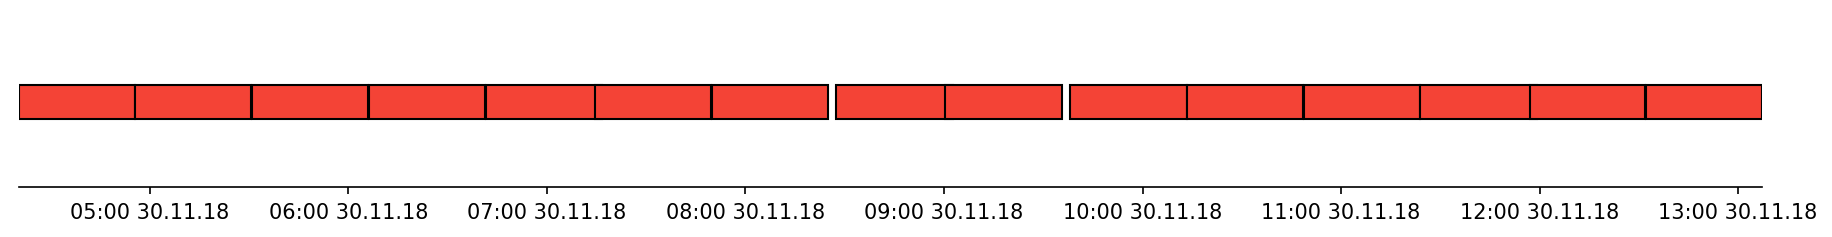

In [69]:
# Simulation Timeline
log_dataframe = generate_dataframe_from_mpiesm_logfile(get_log_output(exps_full[0]))
# Drop the last entry if it's start:
if "start" in log_dataframe.iloc[-1]["State"]:
    end_of_log = log_dataframe.iloc[:-1].tail(30)
else:
    end_of_log = log_dataframe.tail(30)
end_groups = end_of_log.groupby("Run Number")
f, ax = plt.subplots(1, 1, dpi=150, figsize=(15, 1.5))
for name, group in end_groups:
    bdate = group.index[0]
    edate = group.index[1]
    edate, bdate = [mdates.date2num(item) for item in (edate, bdate)]
    # The color is the same as the progressbar below, use the colormeter to figure it out.
    ax.barh(0, edate - bdate, left=bdate, height=0.2, color=(217./255., 83./255., 79./255.),
            edgecolor="black")
ax.set_ylim(-0.5, 0.5)
for direction in ["top", "left", "right"]:
    ax.spines[direction].set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M %d.%m.%y"))

Progressbar showing current state of simulation and "estimated time of arrival" based upon current queueing times and throughput:

In [3]:
# Progress Bar
years_per_day = np.round(df["Hol-T"].Throughput)
years_left = final_year - current_year
days_left = years_left / years_per_day
finishing_date = datetime.datetime.now() + datetime.timedelta(days=days_left)
r_bar = " "+str(current_year)+"/7000"+ ", Throughput ~"+str(years_per_day)+"yrs/day"
from tqdm import tnrange, tqdm_notebook
pbar = tqdm_notebook(total=7000, 
                     desc="Done on: "+finishing_date.strftime("%d %b, %Y"),
                     bar_format="{n}/|/{l_bar} "+r_bar)
pbar.update(7000 - years_left)
pbar.close()

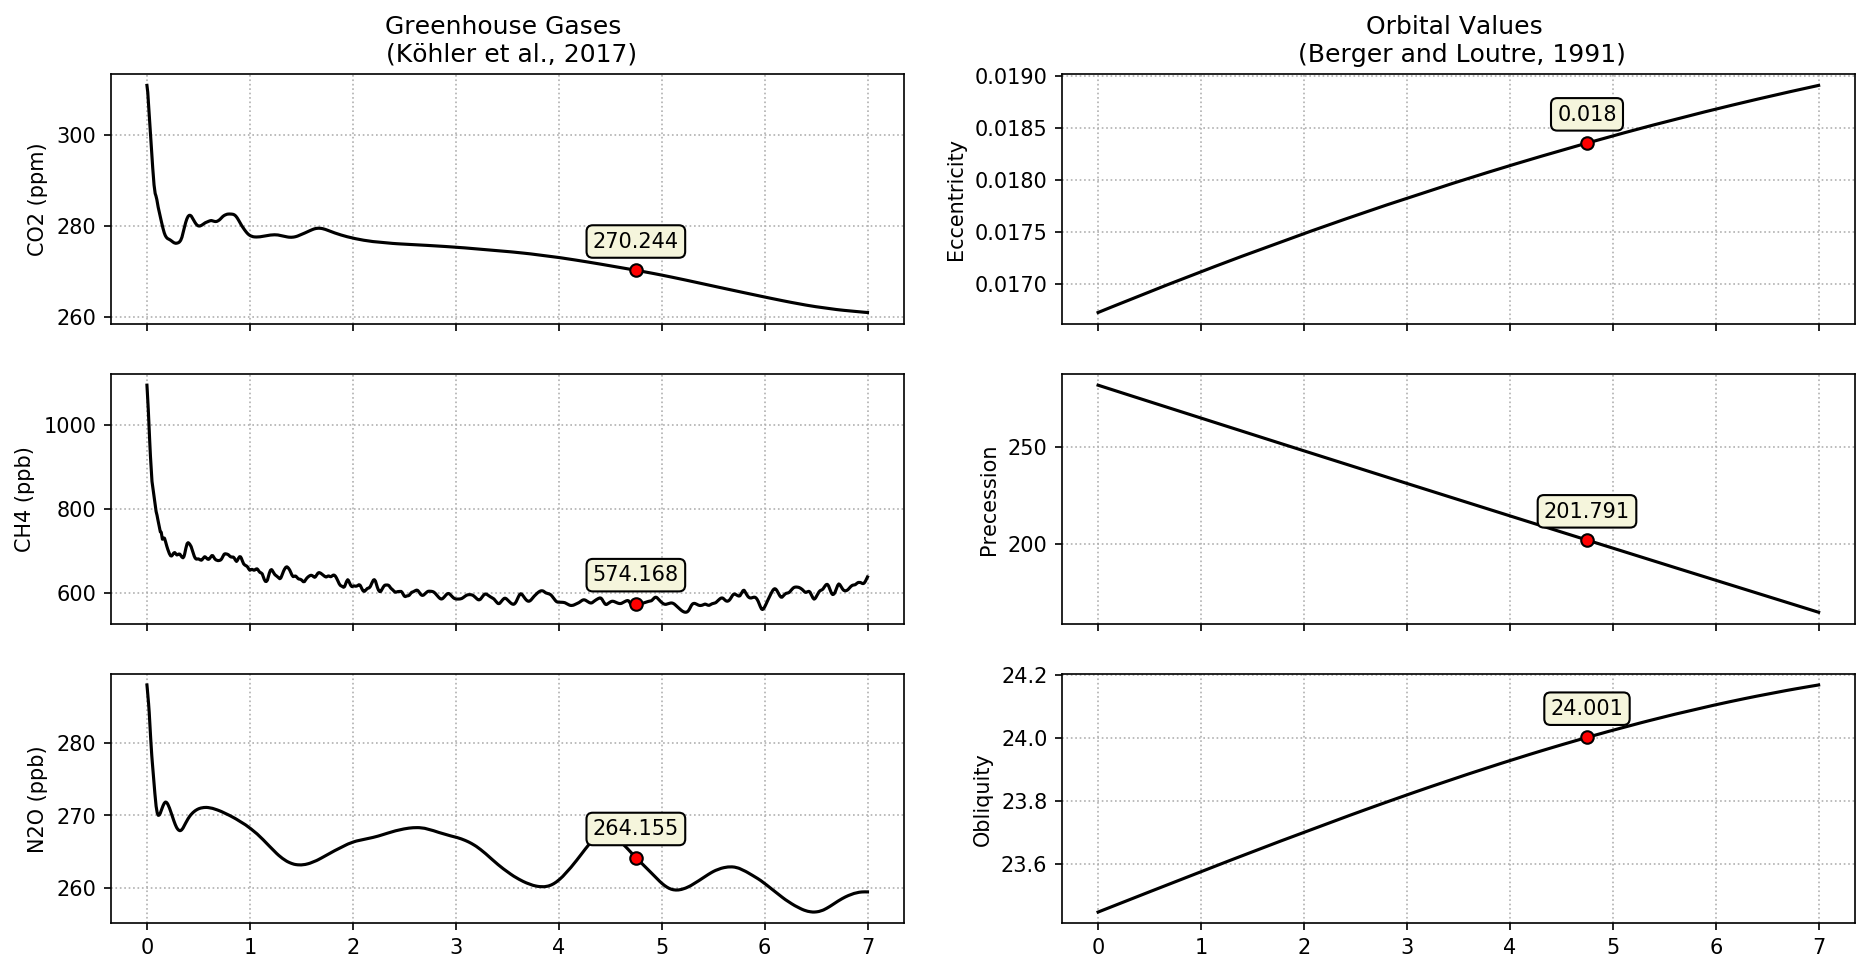

In [4]:
# Get GHG and ORB forcings to show current values:
sftp = client.open_sftp()
sftp.chdir(exps_full[0])
sftp.listdir()
sftp.chdir("scripts")

ORB = sftp.open("Berger_ORB_forcing_0.001ka_resolution.dat")
read_ORB = ORB.readlines()
ORB.close()
ORB = np.array([i.split() for i in read_ORB]).astype(np.float)

GHG = sftp.open("Koehler_GHG_forcing_0.001ka_resolution.dat")
read_GHG = GHG.readlines()
GHG.close()
GHG = np.array([i.split() for i in read_GHG]).astype(np.float)
f, axs = plt.subplots(3, 2, figsize=(15, 7.5), sharex=True, dpi=150)
for gas, ax in zip([1,2,3], axs[:,0].flatten()):
    ax.plot(GHG[:, 0], GHG[:,gas], color="black")
    ax.plot(GHG[current_year,0], GHG[current_year,gas], "o", color="red", mec="black")
    ylim_span = ax.get_ylim()[1] - ax.get_ylim()[0]
    ax.text(GHG[current_year,0], GHG[current_year,gas]+ylim_span*0.075, 
            GHG[current_year,gas].round(3),
            horizontalalignment='center', verticalalignment="bottom",
            bbox=dict(boxstyle="round",
                   ec="black",
                   fc="beige"))
    ax.grid(True, linestyle=":")
for orb, ax in zip([1,2,3], axs[:,1].flatten()):
    ax.plot(ORB[:, 0], ORB[:,orb], color="black")
    ax.plot(ORB[current_year,0], ORB[current_year,orb], "o", color="red", mec="black")
    ylim_span = ax.get_ylim()[1] - ax.get_ylim()[0]
    ax.text(ORB[current_year,0], ORB[current_year,orb] + ylim_span*0.075, 
            ORB[current_year,orb].round(3),
            horizontalalignment='center', verticalalignment="bottom",
            bbox=dict(boxstyle="round",
                   ec="black",
                   fc="beige"))
    ax.grid(True, linestyle=":")
axs[0,0].set_title("Greenhouse Gases \n (Köhler et al., 2017)")
axs[0,1].set_title("Orbital Values \n (Berger and Loutre, 1991)")
axs[0,0].set_ylabel("CO2 (ppm)")
axs[1,0].set_ylabel("CH4 (ppb)")
axs[2,0].set_ylabel("N2O (ppb)")

axs[0,1].set_ylabel("Eccentricity")
axs[1,1].set_ylabel("Precession")
axs[2,1].set_ylabel("Obliquity");
